In [53]:
from __future__ import print_function, division
import sys
sys.path.append('core')

import argparse
import time
import logging
import numpy as np
import torch
from tqdm import tqdm
from raft_stereo import RAFTStereo, autocast
import stereo_datasets as datasets
from utils.utils import InputPadder
from PIL import Image
from matplotlib import pyplot as plt
import copy

class test_args():
    def __init__(self):
        self.restore_ckpt = "raftstereo-middlebury.pth"
        self.dataset = "middlebury_Q"
        self.mixed_precision = False
        self.valid_iters = 32
        self.hidden_dims = [128]*3
        self.corr_implementation = "alt"
        self.shared_backbone = False
        self.corr_levels = 4
        self.corr_radius = 4
        self.n_downsample = 2
        self.slow_fast_gru = False
        self.n_gru_layers = 3

args = test_args()
model = torch.nn.DataParallel(RAFTStereo(args), device_ids=[0])
print(args.restore_ckpt)
if args.restore_ckpt is not None:
    assert args.restore_ckpt.endswith(".pth")
    print("Loading checkpoint...")
    checkpoint = torch.load(args.restore_ckpt)
    model.load_state_dict(checkpoint, strict=True)
    print(f"Done loading checkpoint")
model.cuda()
model.eval()

raftstereo-middlebury.pth
Loading checkpoint...
Done loading checkpoint


DataParallel(
  (module): RAFTStereo(
    (cnet): MultiBasicEncoder(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1

In [47]:
@torch.no_grad()
def validate_middlebury(model, iters=32, split='Q', mixed_prec=False):
    """ Peform validation using the Middlebury-V3 dataset """
    model.eval()
    aug_params = {}
    val_dataset = datasets.Middlebury(aug_params, split=split)

    out_list, epe_list = [], []
    val_id = 0
    (imageL_file, _, _), image1_t, image2_t, flow_gt, valid_gt = val_dataset[val_id]
    #x = image1.permute((1,2,0)).numpy()
    #print(np.array(x))
    #img = Image.fromarray(x.astype('uint8'))
    #plt.imshow(x)
    #plt.show()
    image1 = image1_t[None].cuda()
    image2 = image2_t[None].cuda()

    padder = InputPadder(image1.shape, divis_by=32)
    image1, image2 = padder.pad(image1, image2)


    with autocast(enabled=mixed_prec):
        _, flow_pr = model(image1, image2, iters=iters, test_mode=True)
    #flow_pr = padder.unpad(flow_pr).cpu().squeeze(0)
    print("Shape of ground truth is ",valid_gt.shape)
    #img = Image.fromarray(flow_gt[0].cpu().numpy().astype('uint8'),'L')
    #print(img.mode)

    flow_pr = padder.unpad(flow_pr)
    print("Shape of model prediction is ",flow_pr.shape)
    img = Image.fromarray(np.abs(flow_pr[0][0].cpu().numpy()).astype('uint8'),'L')
    print(img.mode)
    plt.imshow(img)
    plt.show()
    return flow_gt, flow_pr.cpu()
    #assert flow_pr.shape == flow_gt.shape, (flow_pr.shape, flow_gt.shape)


['Adirondack', 'ArtL', 'Carla', 'Jadeplant', 'Motorcycle', 'MotorcycleE', 'Piano', 'PianoL', 'Pipes', 'Playroom', 'Playtable', 'PlaytableP', 'Recycle', 'Shelves', 'Teddy', 'Vintage']
Shape of ground truth is  torch.Size([1984, 2872])
Shape of model prediction is  torch.Size([1, 1, 481, 707])
L


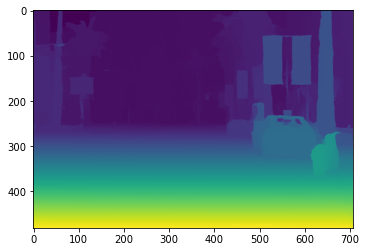

In [54]:
result = validate_middlebury(model)

tensor([[[ -14.4099,  -14.4083,  -14.4153,  ...,  -24.1984,  -24.2104,
           -24.2614],
         [ -14.4046,  -14.3841,  -14.3598,  ...,  -24.1566,  -24.1812,
           -24.2035],
         [ -14.4454,  -14.4305,  -14.3302,  ...,  -24.1384,  -24.1694,
           -24.2099],
         ...,
         [-246.8890, -246.8571, -246.7333,  ..., -243.4083, -242.7776,
          -233.1605],
         [-247.8065, -247.8419, -247.7269,  ..., -245.2746, -244.6567,
          -234.7353],
         [-248.7599, -248.7804, -248.6540,  ..., -246.9554, -245.1902,
          -236.5822]]])


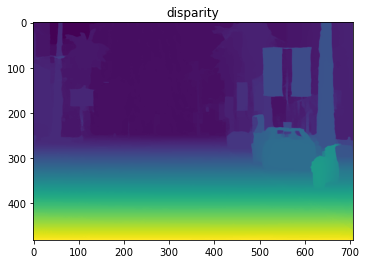

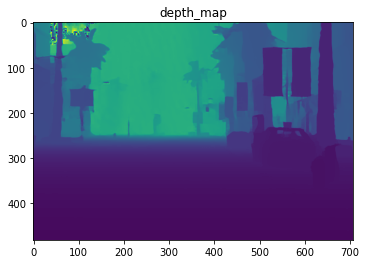

In [68]:
pred = result[1][0]
print(pred)
#print(result[0][0])
pred = pred.numpy()[0]
img = Image.fromarray(np.abs(pred).astype('uint8'),'L')
plt.imshow(img)
plt.title("disparity")
plt.show()
img_w = 707
img_height = 481
fov = 90
focal = 1000
b = 1.6
depth_map = np.ones(pred.shape)
depth_map[:] = focal*b/(np.abs(pred[:]))
#print(depth_map.max())
#print(depth_map.shape)
img = Image.fromarray(depth_map.astype('uint8'),'L')
plt.imshow(img)
plt.title("depth_map")
plt.show()

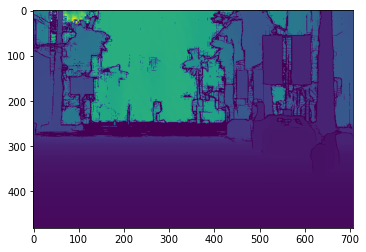

(292029, 3)


array([[1.11233910e-01, 1.11233910e-01, 1.11233910e+02],
       [2.22844849e-01, 1.11422424e-01, 1.11422424e+02],
       [3.35134232e-01, 1.11711411e-01, 1.11711411e+02],
       ...,
       [4.57963929e+00, 3.12040857e+00, 6.51442289e+00],
       [4.59240332e+00, 3.12466078e+00, 6.52330017e+00],
       [4.61054231e+00, 3.13255286e+00, 6.53977633e+00]])

In [59]:
# Filtering large gradient
thres = 1
filtered_map = copy.deepcopy(depth_map)
for i in range(1,480):
    for j in range(1,706):
        if (depth_map[i][j] - depth_map[i-1][j] > thres or depth_map[i][j] - depth_map[i+1][j] > thres or depth_map[i][j] - depth_map[i][j-1] > thres or depth_map[i][j] - depth_map[i][j+1] > thres) and depth_map[i][j]<1000:
            filtered_map[i][j]=0
img = Image.fromarray(filtered_map.astype('uint8'),'L')
plt.imshow(img)
plt.show()

#from utils.utils import bilinear_sampler
#bilinear_depth_map = bilinear_sampler
pc_list = []
for i in range(1,480):
    for j in range(1,706):
        if depth_map[i][j]<1000:
            if depth_map[i][j] - depth_map[i-1][j] < thres and depth_map[i][j] - depth_map[i+1][j] < thres and depth_map[i][j] - depth_map[i][j-1] < thres and depth_map[i][j] - depth_map[i][j+1] < thres:
                x = depth_map[i][j]*j/focal
                y = depth_map[i][j]*i/focal
                z = depth_map[i][j]
                pc_list.append([x,y,z])
pc_list = np.array(pc_list)
print(pc_list.shape)
pc_list
            

In [74]:
#from utils.utils import bilinear_sampler
#bilinear_depth_map = bilinear_sampler
pc_list = []
for i in range(481):
    for j in range(707):
        if depth_map[i][j]<1000:
            x = depth_map[i][j]*j/focal
            y = depth_map[i][j]*i/focal
            z = depth_map[i][j]
            pc_list.append([x,y,z])
pc_list = np.array(pc_list)
print(pc_list.shape)
pc_list

(338196, 3)


array([[  0.        ,   0.        , 111.03501892],
       [  0.11104723,   0.        , 111.04722595],
       [  0.22198618,   0.        , 110.99308777],
       ...,
       [  4.56114792,   3.10987358,   6.47890329],
       [  4.60051065,   3.13226257,   6.52554703],
       [  4.77466084,   3.24622833,   6.76297569]])

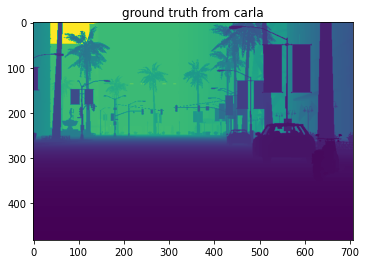

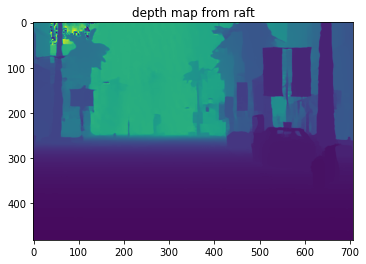

rmse are  26.54340948660911
292029
198071


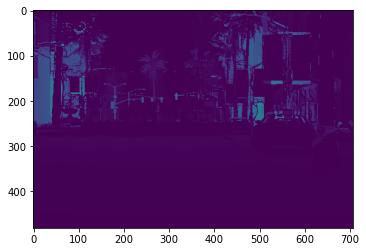

[]

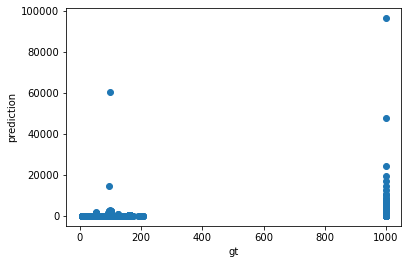

In [70]:
from PIL import Image
import cv2
gt = cv2.imread("D:\\Weeks\\ai_stereo\\RAFT-Stereo-main\\datasets\\Middlebury\\MiddEval3\\trainingQ\\Carla\\depth004788.png",flags = cv2.IMREAD_COLOR)
#gt.show()
gt = np.array(gt)
#img = Image.fromarray(gt.astype('uint8'),'L')
#plt.imshow(img)
#plt.show()
gt = gt[:, :, :3]
gt = gt[:,:,::-1]
gray_depth = ((gt[:,:,0] + gt[:,:,1] * 256.0 + gt[:,:,2] * 256.0 * 256.0)/((256.0 * 256.0 * 256.0) - 1))
gt = gray_depth * 1000

img = Image.fromarray(gt.astype('uint8'),'L')
plt.title("ground truth from carla")
plt.imshow(img)
plt.show()

img = Image.fromarray(depth_map.astype('uint8'),'L')
plt.title("depth map from raft")
plt.imshow(img)
plt.show()
#print(gt)
difference = np.zeros(depth_map.shape)
count = 0
counting = 0
for i in range(1,480):
    for j in range(1,706):
        if (depth_map[i][j] - depth_map[i-1][j] < thres and depth_map[i][j] - depth_map[i+1][j] < thres and depth_map[i][j] - depth_map[i][j-1] < thres and depth_map[i][j] - depth_map[i][j+1] < thres) and depth_map[i][j]<1000:
            difference[i][j] = np.abs(depth_map[i][j] - gt[i][j])
            if difference[i][j] > 1:
                counting = counting+1
            count = count + 1
print("rmse are ",np.sqrt((difference*difference).sum()/count))
print(count)
print(counting)
img = Image.fromarray(difference.astype('uint8'),'L')
plt.imshow(img)
plt.show()


x_axis = np.reshape(gt,481*707)
y_axis = np.reshape(depth_map,481*707)
plt.scatter(x_axis,y_axis)
plt.xlabel("gt")
plt.ylabel("prediction")
plt.plot()



269204


[]

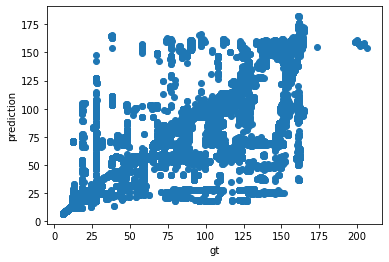

In [58]:
thres = 0.5
gt_point=[]
pred_point = []
for i in range(1,480):
    for j in range(1,706):
        if gt[i][j]<999:
            if depth_map[i][j]<1000:
                if depth_map[i][j] - depth_map[i-1][j] < thres and depth_map[i][j] - depth_map[i+1][j] < thres and depth_map[i][j] - depth_map[i][j-1] < thres and depth_map[i][j] - depth_map[i][j+1] < thres:
                    gt_point.append(gt[i][j])
                    pred_point.append(depth_map[i][j])
print(len(gt_point))
plt.scatter(np.array(gt_point),np.array(pred_point))
plt.xlabel("gt")
plt.ylabel("prediction")
plt.plot()



In [72]:
pc_list = []
for i in range(481):
    for j in range(707):
        if gt[i][j]<400:
            x = gt[i][j]*j/focal
            y = gt[i][j]*i/focal
            z = gt[i][j]
            pc_list.append([x,y,z])
pc_list = np.array(pc_list)
print(pc_list.shape)
pc_list

(337065, 3)


array([[0.00000000e+00, 0.00000000e+00, 1.08463175e+02],
       [1.08770913e-01, 0.00000000e+00, 1.08770913e+02],
       [2.18160165e-01, 0.00000000e+00, 1.09080083e+02],
       ...,
       [3.89135765e+00, 2.65319840e+00, 5.52749667e+00],
       [3.89688515e+00, 2.65319840e+00, 5.52749667e+00],
       [3.90241265e+00, 2.65319840e+00, 5.52749667e+00]])

In [73]:
import open3d
pcd = open3d.open3d.geometry.PointCloud()
pcd.points = open3d.open3d.utility.Vector3dVector(pc_list)
open3d.open3d.visualization.draw_geometries([pcd])

['Adirondack', 'ArtL', 'Carla', 'Jadeplant', 'Motorcycle', 'MotorcycleE', 'Piano', 'PianoL', 'Pipes', 'Playroom', 'Playtable', 'PlaytableP', 'Recycle', 'Shelves', 'Teddy', 'Vintage']
Shape of ground truth is  torch.Size([1984, 2872])
Shape of model prediction is  torch.Size([1, 1, 481, 707])
L


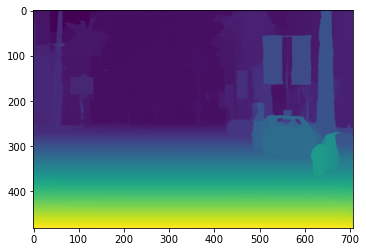

Shape of ground truth is  torch.Size([1984, 2872])
Shape of model prediction is  torch.Size([1, 1, 481, 707])
L


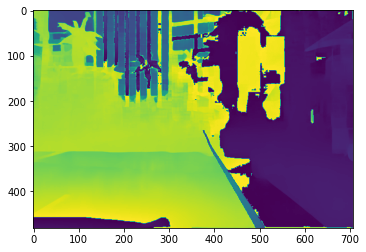

In [33]:
@torch.no_grad()
def forward_backward_consistency(model, iters=32, split='Q', mixed_prec=False):
    """ Peform validation using the Middlebury-V3 dataset """
    model.eval()
    aug_params = {}
    val_dataset = datasets.Middlebury(aug_params, split=split)

    out_list, epe_list = [], []
    val_id = 0
    (imageL_file, _, _), t_image1, t_image2, flow_gt, valid_gt = val_dataset[val_id]
    #x = image1.permute((1,2,0)).numpy()
    #print(np.array(x))
    #img = Image.fromarray(x.astype('uint8'))
    #plt.imshow(x)
    #plt.show()
    image1 = t_image1[None].cuda()
    image2 = t_image2[None].cuda()

    padder = InputPadder(image1.shape, divis_by=32)
    image1, image2 = padder.pad(image1, image2)


    with autocast(enabled=mixed_prec):
        _, flow_l = model(image1, image2, iters=iters, test_mode=True)
    #flow_pr = padder.unpad(flow_pr).cpu().squeeze(0)
    print("Shape of ground truth is ",valid_gt.shape)
    #img = Image.fromarray(flow_gt[0].cpu().numpy().astype('uint8'),'L')
    #print(img.mode)

    flow_l = padder.unpad(flow_l)
    print("Shape of model prediction is ",flow_l.shape)
    img = Image.fromarray(np.abs(flow_l[0][0].cpu().numpy()).astype('uint8'),'L')
    print(img.mode)
    plt.imshow(img)
    plt.show()
    image1 = t_image2[None].cuda()
    image2 = t_image1[None].cuda()

    padder = InputPadder(image1.shape, divis_by=32)
    image1, image2 = padder.pad(image1, image2)


    with autocast(enabled=mixed_prec):
        _, flow_r = model(image1, image2, iters=iters, test_mode=True)
    #flow_pr = padder.unpad(flow_pr).cpu().squeeze(0)
    print("Shape of ground truth is ",valid_gt.shape)
    #img = Image.fromarray(flow_gt[0].cpu().numpy().astype('uint8'),'L')
    #print(img.mode)

    flow_r = padder.unpad(flow_r)
    print("Shape of model prediction is ",flow_r.shape)
    img = Image.fromarray(np.abs(flow_r[0][0].cpu().numpy()).astype('uint8'),'L')
    print(img.mode)
    plt.imshow(img)
    plt.show()
    return  flow_l.cpu(), flow_r.cpu()
    #assert flow_pr.shape == flow_gt.shape, (flow_pr.shape, flow_gt.shape)

disp_1, disp_2 = forward_backward_consistency(model)

[[ -14.409931  -14.408364  -14.415411 ...  -24.198391  -24.210415
   -24.261406]
 [ -14.40473   -14.384213  -14.359831 ...  -24.156588  -24.181204
   -24.20352 ]
 [ -14.445515  -14.430645  -14.330256 ...  -24.138445  -24.169386
   -24.209923]
 ...
 [-246.8889   -246.8571   -246.73323  ... -243.39015  -242.7742
  -233.15465 ]
 [-247.80647  -247.84181  -247.72693  ... -245.27258  -244.67764
  -234.73727 ]
 [-248.75983  -248.78043  -248.65395  ... -246.96649  -245.22954
  -236.60156 ]]
[[ -73.98673 -120.7569  -219.43378 ... -263.6247  -253.31937 -227.1648 ]
 [-108.68068 -122.50962 -219.12889 ... -265.3001  -253.8569  -225.10492]
 [-123.95714 -133.06383 -218.9372  ... -265.32724 -256.4405  -225.17624]
 ...
 [-268.79596 -268.789   -268.66864 ... -272.68823 -273.03284 -277.7375 ]
 [-269.246   -269.27667 -269.23373 ... -258.41678 -261.49683 -276.94305]
 [-269.73727 -269.77634 -269.80646 ... -248.05183 -250.31738 -275.61163]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 

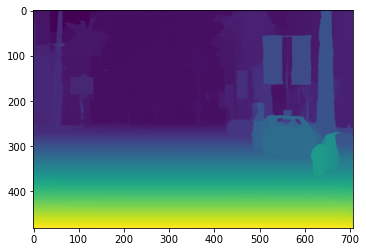

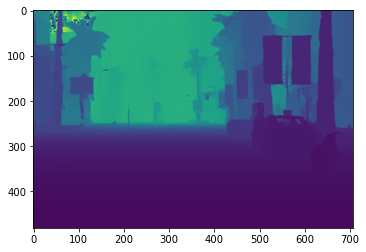

(26901, 3)


array([[1.59385651e+00, 1.13846893e-01, 1.13846893e+02],
       [1.70751366e+00, 1.13834244e-01, 1.13834244e+02],
       [3.77658932e+01, 9.93839294e-01, 9.93839294e+02],
       ...,
       [4.43411222e+01, 3.20765565e+01, 1.57238022e+02],
       [3.73777795e+01, 3.27454906e+01, 1.59734100e+02],
       [3.75284845e+01, 3.27376141e+01, 1.59695679e+02]])

In [49]:
thres = 200
pred_1 = disp_1[0].numpy()[0]
pred_2 = disp_2[0].numpy()[0]
print(pred_1)
print(pred_2)
check = np.ones((481,707))
for i in range(481):
    for j in range(707):
        if np.abs(pred_1[i][j]+pred_2[i][j+round(pred_1[i][j])]) > thres:
            check[i][j] = 0
print(check)

pred = pred_1
print(pred.shape)
img = Image.fromarray(np.abs(pred).astype('uint8'),'L')
plt.imshow(img)
plt.show()
img_w = 707
img_height = 481
fov = 90
focal = 1000
b = 1.6
depth_map = np.ones(pred.shape, np.single)
depth_map[:] = focal*b/np.abs(pred[:])
#print(depth_map.shape)
img = Image.fromarray(depth_map.astype('uint8'),'L')
plt.imshow(img)
plt.show()

pc_list = []
for i in range(1,480):
    for j in range(1,706):
        if depth_map[i][j]<1000:
            if check[i][j] == 1:
                x = depth_map[i][j]*j/focal
                y = depth_map[i][j]*i/focal
                z = depth_map[i][j]
                pc_list.append([x,y,z])
pc_list = np.array(pc_list)
print(pc_list.shape)
pc_list